In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib.pyplot import subplots, style, rc
from tqdm import tqdm
from venn import venn, pseudovenn
from collections import defaultdict
from itertools import count, islice
from functools import lru_cache

In [2]:
%matplotlib inline

In [4]:
from pysam import AlignmentFile
from edgecaselib.formats import load_index
from edgecaselib.util import natsorted_chromosomes
from pickle import dump, load
from os import path

ecx = load_index("../../hg38ext.fa.ecx")

In [5]:
def load_support(filename, is_q):
    support = defaultdict(set)
    with AlignmentFile(filename) as bam:
        for entry in bam:
            if entry.reference_name.endswith("/q") == is_q:
                support[entry.reference_name[:-2]] |= {
                    rp for qp, rp in entry.get_aligned_pairs()
                    if (qp is not None) and (rp is not None)
                }
    return support

In [6]:
def load_chopper(filename, is_q):
    chopper = {}
    with AlignmentFile(filename) as bam:
        for entry in bam:
            if entry.flag & 0x4000 == 0x4000:
                if (entry.flag & 0x8000 == 0x8000) == is_q:
                    chopper[entry.qname] = (entry.reference_name, entry.reference_start, len(entry.seq))
    return chopper

In [7]:
def load_puller(filename, is_q, support):
    puller = {}
    with AlignmentFile(filename) as bam:
        for entry in bam:
            if entry.qname in support:
                if (entry.flag & 0x4000 == 0x4000) and (entry.flag & 3844 == 0):
                    if (entry.flag & 0x8000 == 0x8000) == is_q:
                        if is_q:
                            puller[entry.qname] = (entry.reference_name, entry.reference_start, len(entry.seq))
                        else:
                            puller[entry.qname] = (entry.reference_name, entry.reference_start-entry.query_alignment_start, len(entry.seq))
    return puller

In [8]:
SUBJECT_TO_TRIO = {
    "HG001": "NA12878",
    "HG002": "AshkenazimTrio", "HG003": "AshkenazimTrio", "HG004": "AshkenazimTrio",
    "HG005": "ChineseTrio", "HG006": "ChineseTrio", "HG007": "ChineseTrio",
}

In [8]:
Q_SUPPORT_PKL = "PacBio/q_support.pkl"
Q_CHOPPER_PKL = "PacBio/q_chopper.pkl"
Q_PULLER_PKL = "PacBio/q_puller.pkl"

if path.isfile(Q_SUPPORT_PKL) and path.isfile(Q_CHOPPER_PKL) and path.isfile(Q_PULLER_PKL):
    with open(Q_SUPPORT_PKL, mode="rb") as pkl:
        q_support = load(pkl)
    with open(Q_CHOPPER_PKL, mode="rb") as pkl:
        q_chopper = load(pkl)
    with open(Q_PULLER_PKL, mode="rb") as pkl:
        q_puller = load(pkl)
else:
    q_support, q_chopper, q_puller = {}, {}, {}
    for subject, trio in tqdm(SUBJECT_TO_TRIO.items(), total=len(SUBJECT_TO_TRIO)):
        support = load_support(f"PacBio/{trio}/{subject}/telbam2tailchopper.bam", is_q=True)
        chopper = load_chopper(f"PacBio/{trio}/{subject}/tailchopper.bam", is_q=True)
        puller = load_puller(f"PacBio/{trio}/{subject}/tailpuller.bam", is_q=True, support=support)
        q_support.update(support)
        q_chopper.update(chopper)
        q_puller.update(puller)
    with open(Q_SUPPORT_PKL, mode="wb") as pkl:
        dump(q_support, pkl)
    with open(Q_CHOPPER_PKL, mode="wb") as pkl:
        dump(q_chopper, pkl)
    with open(Q_PULLER_PKL, mode="wb") as pkl:
        dump(q_puller, pkl)

In [24]:
P_SUPPORT_PKL = "PacBio/p_support.pkl"
P_CHOPPER_PKL = "PacBio/p_chopper.pkl"
P_PULLER_PKL = "PacBio/p_puller.pkl"

if path.isfile(P_SUPPORT_PKL) and path.isfile(P_CHOPPER_PKL) and path.isfile(P_PULLER_PKL):
    with open(P_SUPPORT_PKL, mode="rb") as pkl:
        p_support = load(pkl)
    with open(P_CHOPPER_PKL, mode="rb") as pkl:
        p_chopper = load(pkl)
    with open(P_PULLER_PKL, mode="rb") as pkl:
        p_puller = load(pkl)
else:
    p_support, p_chopper, p_puller = {}, {}, {}
    for subject, trio in tqdm(SUBJECT_TO_TRIO.items(), total=len(SUBJECT_TO_TRIO)):
        support = load_support(f"PacBio/{trio}/{subject}/telbam2tailchopper.bam", is_q=False)
        chopper = load_chopper(f"PacBio/{trio}/{subject}/tailchopper.bam", is_q=False)
        puller = load_puller(f"PacBio/{trio}/{subject}/tailpuller.bam", is_q=False, support=support)
        p_support.update(support)
        p_chopper.update(chopper)
        p_puller.update(puller)
    with open(P_SUPPORT_PKL, mode="wb") as pkl:
        dump(p_support, pkl)
    with open(P_CHOPPER_PKL, mode="wb") as pkl:
        dump(p_chopper, pkl)
    with open(P_PULLER_PKL, mode="wb") as pkl:
        dump(p_puller, pkl)

In [10]:
def get_counts(chopper, min_count=50):
    counts = defaultdict(int)
    for _, (chrom, *_) in chopper.items():
        counts[chrom] += 1
    return {chrom: max(counts[chrom], 50) for chrom in natsorted_chromosomes(counts)}

In [20]:
def scatter_one_q_read(ecx, chrom, prime, positions, start, length, ax, i):
    tract_anchor = ecx.loc[(ecx["rname"]==chrom) & (ecx["flag"]==0x4000) & (ecx["prime"]==prime), "pos"].iloc[0]
    sorted_positions = [p for p in sorted(positions)]
    non_covered_positions = [
        p for p in range(max(0, start-tract_anchor), start-tract_anchor+length)
        if p not in sorted_positions
    ]
    ax.scatter(non_covered_positions, [i]*len(non_covered_positions), color="darkblue", marker="s", s=2)
    ax.scatter(sorted_positions, [i]*len(sorted_positions), color="lightgreen", marker="s", s=2)

In [25]:
def scatter_one_p_read(ecx, chrom, prime, positions, start, length, ax, i):
    tract_anchor = ecx.loc[(ecx["rname"]==chrom) & (ecx["flag"]==0x4000) & (ecx["prime"]==prime), "pos"].iloc[0]
    rel_start = start - tract_anchor
    sorted_positions = [p+rel_start for p in sorted(positions) if p+rel_start<=0]
    non_covered_positions = [
        p for p in range(rel_start, min(rel_start+length, 0))
        if p not in sorted_positions
    ]
    ax.scatter(non_covered_positions, [i]*len(non_covered_positions), color="darkblue", marker="s", s=2)
    ax.scatter(sorted_positions, [i]*len(sorted_positions), color="lightgreen", marker="s", s=2)

In [28]:
def plot_support(support, puller, chopper, ecx, is_q, min_count=50, factor=.005):
    counts = get_counts(chopper, min_count=min_count)
    figure, axs = subplots(
        figsize=(7, (sum(counts.values())+len(counts)*20)*factor),
        ncols=1, nrows=len(counts),
        sharex=True,
        gridspec_kw=dict(
            wspace=0, hspace=0,
            height_ratios=counts.values(),
        ),
    )
    chrom2ax = dict(zip(counts, axs))
    ax2i = defaultdict(int)
    prime = 3 if is_q else 5
    for name, positions in tqdm(support.items(), total=len(support)):
        chrom, start, length = puller[name]
        ax = chrom2ax[chrom]
        i = ax2i[ax]
        if is_q:
            scatter_one_q_read(ecx, chrom, prime, positions, start, length, ax, i)
        else:
            scatter_one_p_read(ecx, chrom, prime, positions, start, length, ax, i)
        ax2i[ax] += 1
    for chrom, ax in chrom2ax.items():
        if is_q:
            ax.text(x=0, y=0, s=chrom+" ", ha="right", va="bottom")
            ax.set(
                yticks=[], ylabel=None,
                xlim=(0, ax.get_xlim()[1]), ylim=(0, max(ax2i[ax], min_count)+20),
            )
            ax.spines["right"].set_visible(False)
        else:
            ax.text(x=0, y=0, s=" "+chrom, ha="left", va="bottom")
            ax.set(
                yticks=[], ylabel=None,
                xlim=(ax.get_xlim()[0], 0), ylim=(0, max(ax2i[ax], min_count)+20),
            )
            ax.spines["left"].set_visible(False)
    figure.get_axes()[0].spines["top"].set_visible(False)
    ticks = figure.get_axes()[-1].get_xticks()
    figure.get_axes()[-1].set(
        xticklabels=(ticks / 1000).astype(int).astype(str),
        xlabel="Kbp of telomeric tract",
    )
    return figure

100%|██████████| 2840/2840 [06:58<00:00,  6.78it/s]


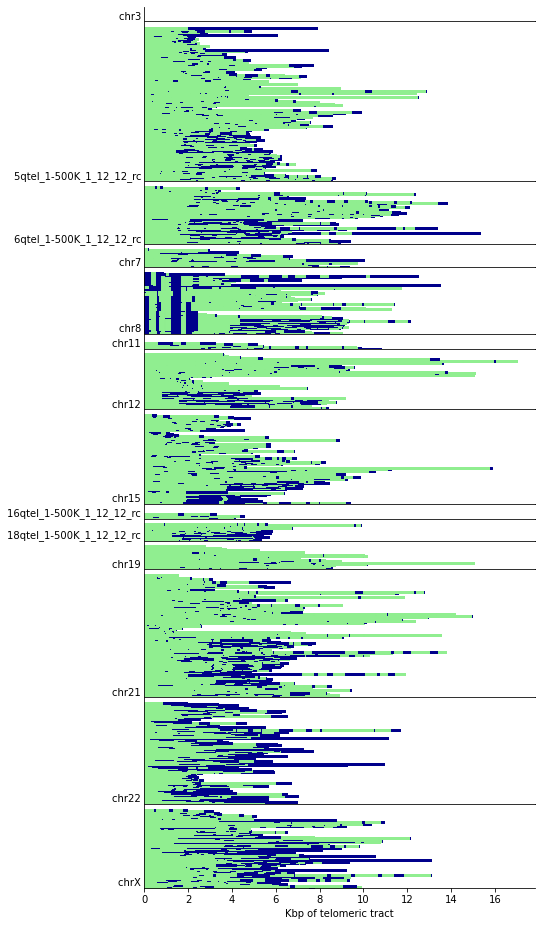

In [14]:
q_figure = plot_support(q_support, q_puller, q_chopper, ecx, is_q=True)
q_figure.savefig("Figure SXB, support.png", dpi=300, bbox_inches="tight")

100%|██████████| 794/794 [10:45<00:00,  1.23it/s]


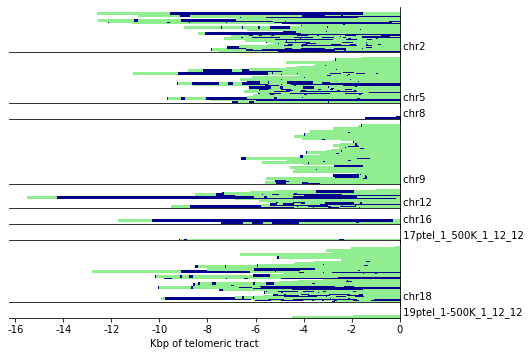

In [29]:
p_figure = plot_support(p_support, p_puller, p_chopper, ecx, is_q=False)
p_figure.savefig("Figure SXA, support.png", dpi=300, bbox_inches="tight")

In [63]:
def get_numerical_support(support, chopper):
    numerical_support = pd.DataFrame(
        data=[
            [len(positions), chopper[name][2], len(positions)/chopper[name][2]]
            for name, positions in support.items()
        ],
        columns=["supported", "length", "fraction"],
    )
    return numerical_support

print("p arm: {:.2f}".format(get_numerical_support(p_support, p_chopper)["fraction"].median()))
print("q arm: {:.2f}".format(get_numerical_support(q_support, q_chopper)["fraction"].median()))

p arm: 0.38
q arm: 0.98


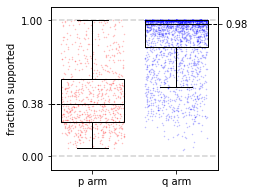

In [171]:
n_figure, ax = subplots(figsize=(3, 3))

p_sup_frac = get_numerical_support(p_support, p_chopper)["fraction"]
q_sup_frac = get_numerical_support(q_support, q_chopper)["fraction"]

ax.plot([-.5, 1.5], [1, 1], color="lightgray", ls="--")
ax.plot([-.5, 1.5], [0, 0], color="lightgray", ls="--")

ax.scatter(np.random.uniform(-.375, .375, size=len(p_sup_frac)), p_sup_frac, color="red", marker=".", s=1, alpha=.25)
pb = ax.boxplot(p_sup_frac, showfliers=False, positions=[0], widths=[.75], medianprops=dict(color="black"))
pm = p_sup_frac.median()
ax.plot([-.5, -.25], [pm, pm], color="black", ls="--", lw=1)

ax.scatter(np.random.uniform(0.625, 1.375, size=len(q_sup_frac)), q_sup_frac, color="blue", marker=".", s=1, alpha=.25)
qb = ax.boxplot(q_sup_frac, showfliers=False, positions=[1], widths=[.75], medianprops=dict(color="black"))
qm = q_sup_frac.median()
tax = ax.twinx()
tax.plot([1.25, 1.5], [qm, qm], color="black", ls="--", lw=1)

_ = ax.set(
    xlim=(-.5, 1.5), ylim=(-.1, 1.1),
    xticklabels=["p arm", "q arm"],
    yticks=[0, pm, 1],
    yticklabels=["0.00", "{:.2f}".format(pm), "1.00"],
    ylabel="fraction supported",
)
_ = tax.set(
    ylim=(-.1, 1.1), yticks=[qm], yticklabels=["{:.2f}".format(qm)],
)

n_figure.savefig("Figure SXC, support.png", dpi=300, bbox_inches="tight")